In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

from attr import dataclass
from datetime import datetime
from dotenv import load_dotenv
from typing import Tuple, List

from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, SamplerV2

load_dotenv()

True

In [2]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super().default(obj)

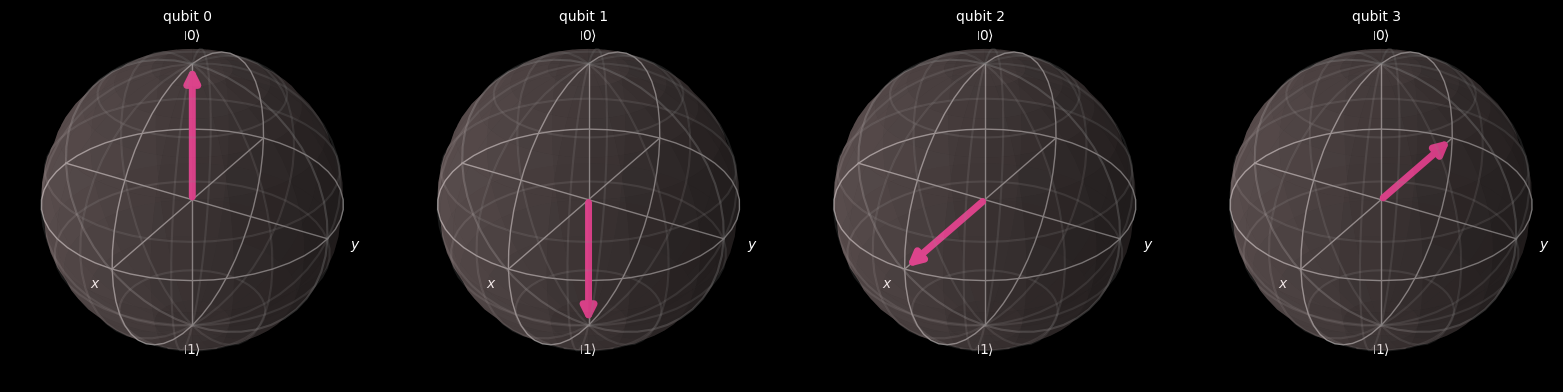

In [3]:
# Let us first draw the 4 states onto the Bloch sphere
def draw_bb84_states():
	"""
	Draws the four BB84 states on the Bloch sphere.
	"""
	qc = QuantumCircuit(4)
	qc.x((1, 3))
	qc.h((2, 3))
	state = Statevector.from_instruction(qc)
	plot_bloch_multivector(state)


draw_bb84_states()

In [4]:
@dataclass
class Metadata:
	"""Container for metadata about BB84/SARG04 protocol execution"""
	trial_idx: int
	n: int
	delta: int
	N: int
	alice_bases: np.ndarray
	alice_bits: np.ndarray
	bob_bases: np.ndarray
	eve_bases: np.ndarray | None

In [5]:
@dataclass
class BB84_SARG04_Result:
	"""Container for BB84/SARG04 protocol execution results"""
	protocol: str  # 'BB84' or 'SARG04'

	n: int  # Desired key bits after reconciliation
	delta: int  # Security parameter
	t: int  # Absolute error threshold for aborting
	N: int  # Total bits sent
	eve_present: bool  # Whether an eavesdropper is present

	alice_bases: np.ndarray  # Alice's basis choices
	alice_bits: np.ndarray  # Alice's bit values
	alice_disclosed_pairs: np.ndarray | None  # Alice's disclosed pairs (if SARG04)
	bob_bases: np.ndarray  # Bob's basis choices
	bob_measured: np.ndarray  # Bob's measurements
	eve_bases: np.ndarray | None  # Eve's basis choices (if present)
	eve_measured: np.ndarray | None  # Eve's measurements (if present)

	num_matched_bits: int  # Number of matched bits after basis reconciliation
	matched_bits: np.ndarray | None  # Boolean array indicating which bits matched
	aborted: bool  # Whether protocol was aborted due to insufficient number of bits

	# The following should hold if the protocol was not aborted:
	# check_bits_used == final_key_length == n < 2n == sifted_length <= num_matched_bits
	sifted_length: int  # Length of sifted key after basis reconciliation
	check_bits_used: int  # Number of check bits used for error estimation
	final_key_length: int  # Length of final key

	alice_check_bits: np.ndarray | None  # Alice's check bits used for error estimation
	bob_check_bits: np.ndarray | None  # Bob's check bits used for error estimation
	eve_check_bits: np.ndarray | None  # Eve's "would-be" check bits
	abs_errors_check_bits: int | None  # Number of errors in check bits
	qber_check_bits: float | None  # QBER estimated from check bits

	alice_final_key: np.ndarray | None  # Alice's final key bits
	bob_final_key: np.ndarray | None  # Bob's final key bits
	eve_final_key: np.ndarray | None  # Eve's "would-be" final key bits
	abs_errors_final_key: int | None  # Number of errors in final key bits
	qber_final_key: float | None  # QBER in final key bits

	successful: bool  # Whether protocol completed successfully, i.e. was not aborted nor had too many errors

	def __str__(self):
		return (
			f"\n{self.protocol} Protocol Result:\n"
			f"Alice:\n"
			f"\tBases:     {self.alice_bases}\n"
			f"\tBits:      {self.alice_bits}\n"
		 f"{f'\tDisclosed: {self.alice_disclosed_pairs[:, 0]}\n'
			f'\t           {self.alice_disclosed_pairs[:, 1]}\n' if self.protocol == 'SARG04' else ''}"
		 f"{f'Eve:\n'
			f'\tBases:     {self.eve_bases}\n'
			f'\tMeasured:  {self.eve_measured}\n' if self.eve_present else ''}"
			f"Bob:\n"
			f"\tBases:     {self.bob_bases}\n"
			f"\tMeasured:  {self.bob_measured}\n"
		 	f"Basis match ({self.num_matched_bits}/{self.N}):\n"
			f"\t           [{' '.join('x' if m else ' ' for m in self.matched_bits)}]\n"
		 f'{f"Check bits | Key bits:\n"
			f"\tAlice: 	   {self.alice_check_bits} | {self.alice_final_key}\n"
		 f"{f'\tEve:   	   {self.eve_check_bits} | {self.eve_final_key}\n' if self.eve_present else ''}"
			f"\tBob:       {self.bob_check_bits} | {self.bob_final_key}\n"
			f"Matched bits:\n"
			f"\t           [{' '.join('x' if a == b else ' ' for a, b in zip(self.alice_check_bits, self.bob_check_bits))}] | "
			f"[{' '.join('x' if a == b else ' ' for a, b in zip(self.alice_final_key, self.bob_final_key))}]\n" if not self.aborted else f"Protocol aborted: {self.aborted}\n"}'
		)

In [6]:
def create_circuits_batch(
		n: int, delta: int, num_circuits: int,
		eve_present: bool = False,
		draw_circuits: List[int] | None = None,
		alice_bases: np.ndarray | None = None,
		alice_bits: np.ndarray | None = None,
		eve_bases: np.ndarray | None = None,
		bob_bases: np.ndarray | None = None
) -> Tuple[List[QuantumCircuit], List[Metadata]]:
	"""
	Creates a batch of independent BB84/SARG04 quantum circuits with random bit-strings for bases and bits.

	:param n: 				Number of key bits desired after basis reconciliation
	:param delta: 			Security parameter to increase the number of bits sent and ensure sufficient amount of bits after reconciliation
	:param num_circuits: 	Number of independent circuits to create
	:param eve_present: 	If True, includes an eavesdropper (Eve) performing intercept-resend attack on all qubits
	:param draw_circuits: 	List of circuit indices to draw and save as png files

	:return: 				Tuple containing the list of QuantumCircuits and the list of corresponding Metadata
	"""

	if draw_circuits is None:
		draw_circuits = []

	N = (4 + delta) * n  # Total bits to send
	qcs = []
	metadata = []

	for trial_idx in range(num_circuits):
		# Use provided bit-strings if given, otherwise generate random ones
		if alice_bases is None:
			alice_bases = np.random.randint(2, size=N)  # Basis bits for Alice
		if alice_bits is None:
			alice_bits = np.random.randint(2, size=N)  	# Value bits for Alice
		if eve_bases is None:
			eve_bases = np.random.randint(2, size=N) if eve_present else None  	# Basis bits for Eve (if present)
		if bob_bases is None:
			bob_bases = np.random.randint(2, size=N)  	# Basis bits for Bob

		qr = QuantumRegister(N, "q")
		cr_bob = ClassicalRegister(N, "bob")
		cr_eve = ClassicalRegister(N, "eve")

		if eve_present:
			qc = QuantumCircuit(qr, cr_eve, cr_bob)
		else:
			qc = QuantumCircuit(qr, cr_bob)

		# Alice encodes her bits
		for i in range(N):
			if alice_bits[i]:
				qc.x(i)  # Encode bit 1
			if alice_bases[i]:
				qc.h(i)  # Change to X-basis
		qc.barrier()

		# If Eve is present, she intercepts and measures the qubits
		if eve_present:
			for i in range(N):
				if eve_bases[i]:
					qc.h(i)  # Measure in X-basis
				qc.measure(i, cr_eve[i])
				# Eve resends the qubit based on her measurement
				qc.reset(i)
				with qc.if_test((cr_eve[i], 1)):
					qc.x(i)  # Encode bit 1 if Eve measured 1
				if eve_bases[i]:
					qc.h(i)  # Change back to original basis
		qc.barrier()

		# Bob measures the qubits
		for i in range(N):
			if bob_bases[i]:
				qc.h(i)  # Measure in X-basis
			qc.measure(i, cr_bob[i])

		# Draw the circuit and save to png
		if trial_idx in draw_circuits:
			qc.draw(output="mpl", fold=-1, filename=f"bb84_sarg04_circuit_trial_{trial_idx}.png")

		qcs.append(qc)
		metadata.append(Metadata(
			trial_idx=trial_idx,
			n=n,
			delta=delta,
			N=N,
			alice_bases=alice_bases,
			alice_bits=alice_bits,
			bob_bases=bob_bases,
			eve_bases=eve_bases
		))

	return qcs, metadata

In [7]:
def extract_results_from_batch(
		job_results,
		metadata_list: List[Metadata],
		t: int,
		eve_present: bool = False,
		sarg04: bool = False,
		alice_disclosed_pairs: np.ndarray | None = None
) -> List[BB84_SARG04_Result]:
	"""
	Extracts BB84/SARG04 protocol results from a batch of executed quantum circuits.

	:param job_results: Qiskit job results
	:param metadata_list: List of Metadata corresponding to each circuit
	:param t: Error threshold for aborting the protocol
	:param eve_present: Whether an eavesdropper is present
	:param sarg04: Whether SARG04 protocol is used; changes basis reconciliation

	:return: List of BB84_SARG04_Result objects (one per circuit/trial)
	"""
	results = []

	for metadata, job_result in zip(metadata_list, job_results):
		n = metadata.n
		N = metadata.N
		alice_bases = metadata.alice_bases
		alice_bits = metadata.alice_bits
		bob_bases = metadata.bob_bases
		eve_bases = metadata.eve_bases

		bob_bits = np.zeros(N, dtype=int)
		eve_bits = np.zeros(N, dtype=int) if eve_present else None

		bob_counts = job_result.data.bob.get_counts()
		if len(bob_counts) != 1:
			raise ValueError(f"Unexpected number of Bob measurement outcomes: {len(bob_counts)}")
		bob_bitstring = list(bob_counts.keys())[0]  # A single shot is always done
		for i in range(N):  # Qiskit returns bitstrings in little-endian order
			bob_bits[i] = int(bob_bitstring[N - 1 - i])

		if eve_present:
			eve_counts = job_result.data.eve.get_counts()
			if len(eve_counts) != 1:
				raise ValueError(f"Unexpected number of Eve measurement outcomes: {len(eve_counts)}")
			eve_bitstring = list(eve_counts.keys())[0]
			for i in range(N):
				eve_bits[i] = int(eve_bitstring[N - 1 - i])

		# Basis reconciliation
		if sarg04:
			# In SARG04 Alice discloses pairs of bits depending on her basis choice:
			# Correct bit in her chosen basis, random bit in the other basis
			if alice_disclosed_pairs is None:
				alice_disclosed_pairs = []
				extra_bits = np.random.randint(2, size=N)
				for i in range(N):
					if alice_bases[i] == 0:
						alice_disclosed_pairs.append([alice_bits[i], extra_bits[i]])
					else:
						alice_disclosed_pairs.append([extra_bits[i], alice_bits[i]])
				alice_disclosed_pairs = np.array(alice_disclosed_pairs)
			# Bob uses Alice's disclosed pairs to flag valid ones, i.e.,
			# the ones for which he can determine Alice's bit unambiguously.
			# Those are the ones that correspond to same chosen basis, but different bits measured;
			# since then he knows Alice's bit must be the other one in the pair.
			match = bob_bits != alice_disclosed_pairs[np.arange(N), bob_bases]
			# Now he corrects his matched bits to the other ones in Alice's pairs
			bob_sifted = alice_disclosed_pairs[np.arange(N)[match], 1 - bob_bases[match]]
		else:  # Otherwise if BB84, Alice just discloses her base
			match = bob_bases == alice_bases
			bob_sifted = bob_bits[match]
		alice_sifted = alice_bits[match]

		# If N' < 2n i.e. there is not sufficiently enough bits left,
		# the protocol should be aborted
		if len(alice_sifted) < 2 * n:
			results.append(
				BB84_SARG04_Result(
					protocol="SARG04" if sarg04 else "BB84",

					n=n,
					delta=metadata.delta,
					t=t,
					N=N,
					eve_present=eve_present,

					alice_bases=alice_bases,
					alice_bits=alice_bits,
					alice_disclosed_pairs=alice_disclosed_pairs if sarg04 else None,
					bob_bases=bob_bases,
					bob_measured=bob_bits,
					eve_bases=eve_bases,
					eve_measured=eve_bits,

					num_matched_bits=len(alice_sifted),
					matched_bits=match,
					aborted=True,

					sifted_length=len(alice_sifted),
					check_bits_used=0,
					final_key_length=0,

					alice_check_bits=None,
					bob_check_bits=None,
					eve_check_bits=None,
					abs_errors_check_bits=None,
					qber_check_bits=None,

					alice_final_key=None,
					bob_final_key=None,
					eve_final_key=None,
					abs_errors_final_key=None,
					qber_final_key=None,

					successful=False
				)
			)
			continue

		# Otherwise, truncate to 2n bits
		alice_sifted = alice_sifted[:2 * n]
		bob_sifted = bob_sifted[:2 * n]
		eve_sifted = eve_bits[match][:2 * n] if eve_present else None

		# Error estimation via check bits
		check_bits_alice = alice_sifted[:n]
		check_bits_bob = bob_sifted[:n]
		check_bits_eve = eve_sifted[:n] if eve_present else None
		error_abs_check_bits = np.sum(check_bits_alice != check_bits_bob)
		qber_check_bits = error_abs_check_bits / n

		key_alice = alice_sifted[n:]
		key_bob = bob_sifted[n:]
		key_eve = eve_sifted[n:] if eve_present else None
		error_abs_key = np.sum(key_alice != key_bob)
		qber_final_key = error_abs_key / n

		successful = error_abs_check_bits <= t

		# Append result
		results.append(
			BB84_SARG04_Result(
				protocol="SARG04" if sarg04 else "BB84",

				n=n,
				delta=metadata.delta,
				t=t,
				N=N,
				eve_present=eve_present,

				alice_bases=alice_bases,
				alice_bits=alice_bits,
				alice_disclosed_pairs=alice_disclosed_pairs if sarg04 else None,
				bob_bases=bob_bases,
				bob_measured=bob_bits,
				eve_bases=eve_bases,
				eve_measured=eve_bits,

				num_matched_bits=len(alice_sifted),
				matched_bits=match,
				aborted=False,

				sifted_length=len(alice_sifted),
				check_bits_used=n,
				final_key_length=len(key_alice),

				alice_check_bits=check_bits_alice,
				bob_check_bits=check_bits_bob,
				eve_check_bits=check_bits_eve,
				abs_errors_check_bits=error_abs_check_bits,
				qber_check_bits=qber_check_bits,

				alice_final_key=key_alice,
				bob_final_key=key_bob,
				eve_final_key=key_eve,
				abs_errors_final_key=error_abs_key,
				qber_final_key=qber_final_key,

				successful=successful
			)
		)

	return results

In [11]:
def run_bb84_n_sarg04_batch(
		n: int = 8, delta: int = 0, t: int = 2,
		eve_present: bool = False, sarg04: bool = False,
		num_trials = 100, run_on_hw: bool = False,
		optimization_level: int = 1, service: QiskitRuntimeService = None,
		verbose: bool = False, draw_circuits: List[int] | None = None,
		return_full_results: bool = False,
		alice_bases: np.ndarray | None = None,
		alice_bits: np.ndarray | None = None,
		alice_disclosed_pairs: np.ndarray | None = None,
		eve_bases: np.ndarray | None = None,
		bob_bases: np.ndarray | None = None
) -> dict:
	"""
	Runs a batch of BB84/SARG04 protocol trials on a quantum backend (hardware or simulator)
	in a single job submission.

	:param n: 					Number of key bits desired after basis reconciliation
	:param delta: 				Security parameter to increase the number of bits sent
								and ensure sufficient amount of bits after reconciliation
	:param t: 					Absolute error threshold for aborting
	:param eve_present: 		Whether an eavesdropper (Eve) is present performing intercept-resend attack on all qubits
	:param sarg04: 				If True, uses SARG04 protocol instead of BB84
	:param num_trials: 			Number of independent trials to run in the batch
	:param run_on_hw: 			If True, runs on real quantum hardware; otherwise uses simulator
	:param optimization_level: 	Optimization level for transpilation (0-3)
	:param service: 			QiskitRuntimeService instance; if None, a new one will be created from environment variables
	:param verbose: 			If True, prints progress information
	:param draw_circuits: 		List of circuit indices to draw and save as png files for each trial

	:return: 					Dictionary of the following structure:
		{
			backend_name: str,
			execution_time: float,
			aggr_results: {
				total_trials: int,
				abort_count: int,
				abort_rate: float,
				tm_errors_count: int,
				tm_errors_rate: float,
				successful_count: int,
				successful_rate: float,
				mean_qber_cb: float,
				std_qber_cb: float,
				mean_qber_fk: float,
				std_qber_fk: float
			},
			full_results: [
				{
					metadata: Metadata,
					result: BB84_SARG04_Result
				}
			]
		}
	"""

	if verbose:
		print(f"\n{'='*110}")
		print(f"Running {'SARG04' if sarg04 else 'BB84'} protocol batch: n={n}, delta={delta}, t={t}, "
			  f"{'with Eve' if eve_present else 'no Eve'}, "
			  f"{'on hardware' if run_on_hw else 'on simulator'}, "
			  f"num_trials={num_trials}, optimization_level={optimization_level}")
		print(f"{'='*110}")
	start_time = datetime.now()

	# Create batch of circuits
	if verbose:
		print(f"\n[1/5] Creating circuits...")
	qcs, metadata = create_circuits_batch(n, delta, num_trials, eve_present, draw_circuits,
										  alice_bases, alice_bits,
										  eve_bases, bob_bases)
	assert len(qcs) == len(metadata) == num_trials
	if verbose:
		print(f"Created {num_trials} circuits.")

	# Set up backend
	if verbose:
		print(f"\n[2/5] Setting up backend...")
	# We will use IBM's QiskitRuntimeService
	if service is None:
		service = QiskitRuntimeService(token=os.environ["IBM_TOKEN"], channel="ibm_cloud", instance=os.environ["IBM_CRN"])
	if verbose:
		print(f"Available backends: {service.backends()}")
	# Selecting a hardware backend as base
	backend = service.least_busy(operational=True, simulator=False)
	if not run_on_hw:
		# Turning it into a simulator derived from backend's properties
		backend = AerSimulator.from_backend(backend)
		# Use MPS method to enable running larger circuits that require no entanglement
		backend.set_options(method="matrix_product_state")
	backend_name = backend.name if hasattr(backend, "name") else "Unknown name"
	if verbose:
		print("Backend set up:", backend_name)

	# Transpile circuits
	if verbose:
		print(f"\n[3/5] Transpiling circuits...")
	tqcs = transpile(
		qcs, backend=backend,
		optimization_level=optimization_level,  # 0 = no optimization -> 3 = heavy optimization
	)
	if verbose:
		print(f"Transpiled {len(tqcs)} circuits.")

	if verbose:
		print(f"\n[4/5] Running circuits...")
	# Submit and execute the batch of jobs
	with Batch(backend) as batch:
		sampler = SamplerV2(mode=batch)
		job = sampler.run(tqcs, shots=1)
		if verbose:
			print(f"\t Job ID: {job.job_id()}")
			print(f"\t Patiently awaiting results...")
		res = job.result()
	if verbose:
		print(f"Execution complete!")

	# Extract and analyze results
	if verbose:
		print(f"\n[5/5] Extracting and analyzing results...")
	results = extract_results_from_batch(
		res, metadata, t, eve_present, sarg04,
		alice_disclosed_pairs
	)
	# Calculate statistics
	assert sum(1 for r in results if r.aborted and r.successful) == 0
	aborted = sum(1 for r in results if r.aborted)
	not_aborted_but_tmm = sum(1 for r in results if not r.aborted and not r.successful)
	successful = sum(1 for r in results if r.successful)
	abs_errors_check_bits = [r.abs_errors_check_bits for r in results if not r.aborted]
	qbers_check_bits = [r.qber_check_bits for r in results if not r.aborted]
	abs_errors_final_key = [r.abs_errors_final_key for r in results if not r.aborted]
	qbers_final_key = [r.qber_final_key for r in results if not r.aborted]

	stats = {
		"total_trials": num_trials,
		"abort_count": aborted,
		"abort_rate": aborted / num_trials,
		"tmm_count": not_aborted_but_tmm,
		"tmm_rate": not_aborted_but_tmm / (num_trials - aborted) if (num_trials - aborted) > 0 else 0.0,
		"successful_count": successful,
		"successful_rate": successful / num_trials,

		"mean_qber_cb": np.mean(qbers_check_bits) if qbers_check_bits else None,
		"std_qber_cb": np.std(qbers_check_bits) if qbers_check_bits else None,
		"mean_qber_fk": np.mean(qbers_final_key) if qbers_final_key else None,
		"std_qber_fk": np.std(qbers_final_key) if qbers_final_key else None,
	}

	backend_metrics_timestamps = job.metrics()["timestamps"]

	result = {
		"backend_name": backend_name,
		"timestamp_created": str(backend_metrics_timestamps["created"]),
		"timestamp_finished": str(backend_metrics_timestamps["finished"]),
		"aggr_results": stats,
	}
	end_time = datetime.now()
	if verbose:
		print(f"Done! Total time: {end_time - start_time}")

		# Print just some result summary
		print(f"Backend result summary:")
		print(json.dumps(result, indent=4))

	if return_full_results:
		result["full_results"] = [
			{
				"metadata": metadata[idx],
				"result": results[idx]
			} for idx in range(num_trials)
		]

	return result

In [9]:
service = QiskitRuntimeService(token=os.environ["IBM_TOKEN"], channel="ibm_cloud", instance=os.environ["IBM_CRN"])

qiskit_runtime_service._discover_account:WARNING:2025-12-30 05:29:28,741: Loading account with the given token. A saved account will not be used.



Running BB84 protocol batch: n=3, delta=0, t=2, with Eve, on simulator, num_trials=1, optimization_level=1

[1/5] Creating circuits...
Created 1 circuits.

[2/5] Setting up backend...
Available backends: [<IBMBackend('ibm_fez')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_marrakesh')>]
Backend set up: aer_simulator_from(ibm_fez)

[3/5] Transpiling circuits...
Transpiled 1 circuits.

[4/5] Running circuits...
	 Job ID: dd68ad38-906b-490f-b237-50bb76d502ff
	 Patiently awaiting results...
Execution complete!

[5/5] Extracting and analyzing results...
Done! Total time: 0:00:10.133640
Backend result summary:
{
    "backend_name": "aer_simulator_from(ibm_fez)",
    "timestamp_created": "2025-12-30 05:32:13.996657",
    "timestamp_finished": "2025-12-30 05:32:13.996661",
    "aggr_results": {
        "total_trials": 1,
        "abort_count": 0,
        "abort_rate": 0.0,
        "tmm_count": 0,
        "tmm_rate": 0.0,
        "successful_count": 1,
        "successful_rate": 1.0,
        

{'backend_name': 'aer_simulator_from(ibm_fez)',
 'timestamp_created': '2025-12-30 05:32:13.996657',
 'timestamp_finished': '2025-12-30 05:32:13.996661',
 'aggr_results': {'total_trials': 1,
  'abort_count': 0,
  'abort_rate': 0.0,
  'tmm_count': 0,
  'tmm_rate': 0.0,
  'successful_count': 1,
  'successful_rate': 1.0,
  'mean_qber_cb': np.float64(0.0),
  'std_qber_cb': np.float64(0.0),
  'mean_qber_fk': np.float64(0.3333333333333333),
  'std_qber_fk': np.float64(0.0)},
 'full_results': [{'metadata': Metadata(trial_idx=0, n=3, delta=0, N=12, alice_bases=array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0]), alice_bits=array([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]), bob_bases=array([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1]), eve_bases=array([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1])),
   'result': BB84_SARG04_Result(protocol='BB84', n=3, delta=0, t=2, N=12, eve_present=True, alice_bases=array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0]), alice_bits=array([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]), alice_disclosed_pairs=Non

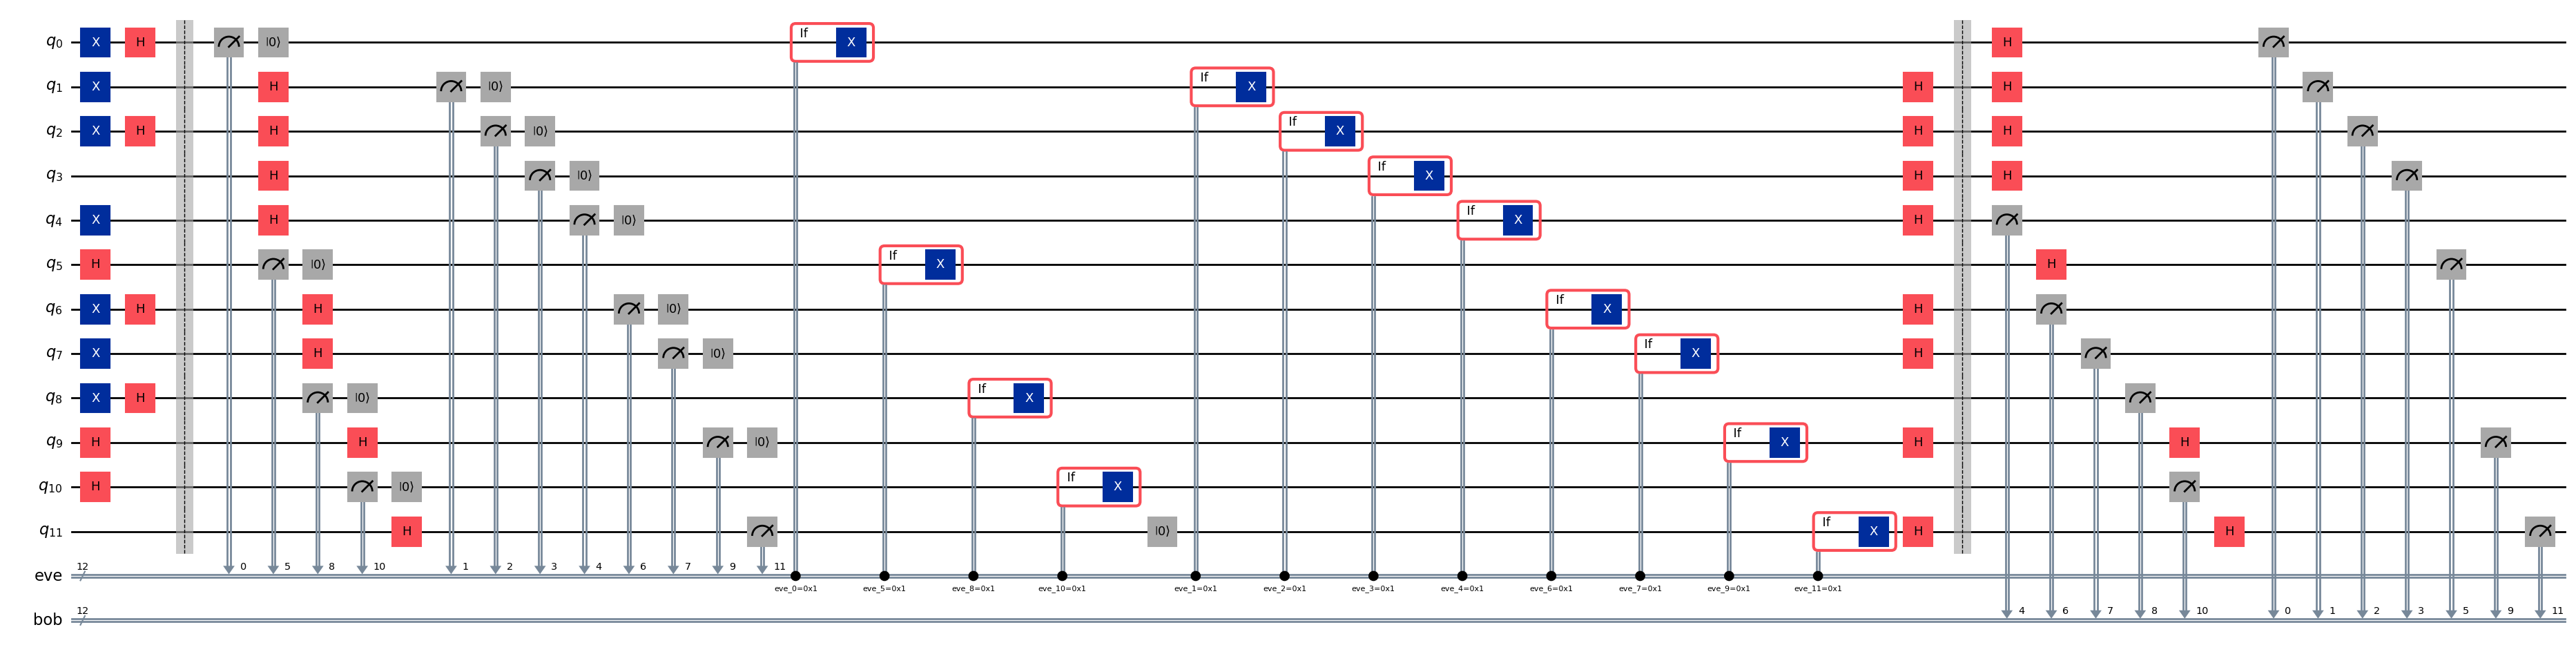

In [12]:
alice_bases = np.array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0])
alice_bits  = np.array([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0])
eve_bases   = np.array([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1])
bob_bases   = np.array([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1])
alice_disclosed_pairs = np.array([[0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0],
								  [1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]]).T

run_bb84_n_sarg04_batch(
		n=3, delta=0, t=2,
		eve_present=True, sarg04=False,
		num_trials=1, run_on_hw=False,
		optimization_level=1,
		service=service,
		verbose=True,
		return_full_results=True,
		alice_bases=alice_bases,
		alice_bits= alice_bits,
		eve_bases=  eve_bases,
		bob_bases=  bob_bases,
		draw_circuits=[0],
	)

In [34]:
def run_example_test_case(
		n, delta, t,
		run_on_hw,
):
	r_bb84_no_eve = run_bb84_n_sarg04_batch(
		n=n, delta=delta, t=t,
		eve_present=False, sarg04=False,
		num_trials=1, run_on_hw=run_on_hw,
		optimization_level=1,
		service=service,
		verbose=False,
		return_full_results=True,
		alice_bases=alice_bases,
		alice_bits= alice_bits,
		eve_bases=  eve_bases,
		bob_bases=  bob_bases
	)
	r_bb84_eve = run_bb84_n_sarg04_batch(
		n=n, delta=delta, t=t,
		eve_present=True, sarg04=False,
		num_trials=1, run_on_hw=run_on_hw,
		optimization_level=1,
		service=service,
			verbose=False,
		return_full_results=True,
		alice_bases=alice_bases,
		alice_bits= alice_bits,
		eve_bases=  eve_bases,
		bob_bases=  bob_bases
	)
	r_sarg04_no_eve = run_bb84_n_sarg04_batch(
		n=n, delta=delta, t=t,
		eve_present=False, sarg04=True,
		num_trials=1, run_on_hw=run_on_hw,
		optimization_level=1,
		service=service,
		verbose=False,
		return_full_results=True,
		alice_bases=alice_bases,
		alice_bits= alice_bits,
		alice_disclosed_pairs=alice_disclosed_pairs,
		eve_bases=  eve_bases,
		bob_bases=  bob_bases
	)
	r_sarg04_eve = run_bb84_n_sarg04_batch(
		n=n, delta=delta, t=t,
		eve_present=True, sarg04=True,
		num_trials=1, run_on_hw=run_on_hw,
		optimization_level=1,
		service=service,
		verbose=False,
		return_full_results=True,
		alice_bases=alice_bases,
		alice_bits= alice_bits,
		alice_disclosed_pairs=alice_disclosed_pairs,
		eve_bases=  eve_bases,
		bob_bases=  bob_bases
	)

	print(r_bb84_no_eve["full_results"][0]["result"])
	print(r_bb84_eve["full_results"][0]["result"])
	print(r_sarg04_no_eve["full_results"][0]["result"])
	print(r_sarg04_eve["full_results"][0]["result"])

	return r_bb84_no_eve, r_bb84_eve, r_sarg04_no_eve, r_sarg04_eve

In [35]:
run_example_test_case(
	n=3, delta=0, t=0,
	run_on_hw=False,
)


BB84 Protocol Result:
Alice:
	Bases:     [1 0 1 0 0 1 1 0 1 1 1 0]
	Bits:      [1 1 1 0 1 0 1 1 1 0 0 0]
Bob:
	Bases:     [1 1 1 1 0 1 0 0 0 1 0 1]
	Measured:  [1 1 1 1 1 0 1 1 1 0 0 0]
Basis match (6/12):
	           [x   x   x x   x   x    ]
Check bits | Key bits:
	Alice: 	   [1 1 1] | [0 1 0]
	Bob:       [1 1 1] | [0 1 0]
Matched bits:
	           [x x x] | [x x x]


BB84 Protocol Result:
Alice:
	Bases:     [1 0 1 0 0 1 1 0 1 1 1 0]
	Bits:      [1 1 1 0 1 0 1 1 1 0 0 0]
Eve:
	Bases:     [0 1 1 1 1 0 1 1 0 1 0 1]
	Measured:  [1 1 1 0 0 1 1 1 0 0 0 1]
Bob:
	Bases:     [1 1 1 1 0 1 0 0 0 1 0 1]
	Measured:  [0 1 1 0 0 1 1 0 0 0 0 1]
Basis match (6/12):
	           [x   x   x x   x   x    ]
Check bits | Key bits:
	Alice: 	   [1 1 1] | [0 1 0]
	Eve:   	   [1 1 0] | [1 1 0]
	Bob:       [0 1 0] | [1 0 0]
Matched bits:
	           [  x  ] | [    x]


SARG04 Protocol Result:
Alice:
	Bases:     [1 0 1 0 0 1 1 0 1 1 1 0]
	Bits:      [1 1 1 0 1 0 1 1 1 0 0 0]
	Disclosed: [0 1 0 0 1 0 0 1 1 0 1 

In [38]:
run_example_test_case(
	n=3, delta=0, t=0,
	run_on_hw=True,
)


BB84 Protocol Result:
Alice:
	Bases:     [1 0 1 0 0 1 1 0 1 1 1 0]
	Bits:      [1 1 1 0 1 0 1 1 1 0 0 0]
Bob:
	Bases:     [1 1 1 1 0 1 0 0 0 1 0 1]
	Measured:  [1 0 1 1 1 0 1 1 1 0 0 0]
Basis match (6/12):
	           [x   x   x x   x   x    ]
Check bits | Key bits:
	Alice: 	   [1 1 1] | [0 1 0]
	Bob:       [1 1 1] | [0 1 0]
Matched bits:
	           [x x x] | [x x x]


BB84 Protocol Result:
Alice:
	Bases:     [1 0 1 0 0 1 1 0 1 1 1 0]
	Bits:      [1 1 1 0 1 0 1 1 1 0 0 0]
Eve:
	Bases:     [0 1 1 1 1 0 1 1 0 1 0 1]
	Measured:  [1 0 1 0 0 0 1 0 1 1 1 1]
Bob:
	Bases:     [1 1 1 1 0 1 0 0 0 1 0 1]
	Measured:  [1 0 1 0 0 0 1 1 1 1 1 1]
Basis match (6/12):
	           [x   x   x x   x   x    ]
Check bits | Key bits:
	Alice: 	   [1 1 1] | [0 1 0]
	Eve:   	   [1 1 0] | [0 0 1]
	Bob:       [1 1 0] | [0 1 1]
Matched bits:
	           [x x  ] | [x x  ]


SARG04 Protocol Result:
Alice:
	Bases:     [1 0 1 0 0 1 1 0 1 1 1 0]
	Bits:      [1 1 1 0 1 0 1 1 1 0 0 0]
	Disclosed: [0 1 0 0 1 0 0 1 1 0 1 

In [14]:
# Run simulation tests for how delta affects the abort/success rates
num_trials = 256
n = 8
t = 2
deltas = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
optimization_level = 1
results_bb84_no_eve = []
results_bb84_w_eve = []
#results_sarg04_no_eve = []
#results_sarg04_w_eve = []

service = QiskitRuntimeService(token=os.environ["IBM_TOKEN"], channel="ibm_cloud", instance=os.environ["IBM_CRN"])

for delta in deltas:
	print(f"\ndelta={delta}:")
	print(f"Running bb84_no_eve...")
	res_bb84_no_eve = run_bb84_n_sarg04_batch(
		n=n, delta=delta, t=t,
		eve_present=False, sarg04=False,
		num_trials=num_trials, run_on_hw=False,
		optimization_level=optimization_level,
		service=service,
		verbose=False
	)
	results_bb84_no_eve.append(res_bb84_no_eve)

	print(f"Running bb84_w_eve...")
	res_bb84_w_eve = run_bb84_n_sarg04_batch(
		n=n, delta=delta, t=t,
		eve_present=True, sarg04=False,
		num_trials=num_trials, run_on_hw=False,
		optimization_level=optimization_level,
		service=service,
		verbose=False
	)
	results_bb84_w_eve.append(res_bb84_w_eve)

	#print(f"Running sarg04_no_eve...")
	#res_sarg04_no_eve = run_bb84_n_sarg04_batch(
	#	n=n, delta=delta, t=t,
	#	eve_present=False, sarg04=True,
	#	num_trials=num_trials, run_on_hw=False,
	#	optimization_level=optimization_level,
	#	service=service,
	#	verbose=False
	#)
	#results_sarg04_no_eve.append(res_sarg04_no_eve)

	#print(f"Running sarg04_w_eve...")
	#res_sarg04_w_eve = run_bb84_n_sarg04_batch(
	#	n=n, delta=delta, t=t,
	#	eve_present=True, sarg04=True,
	#	num_trials=num_trials, run_on_hw=False,
	#	optimization_level=optimization_level,
	#	service=service,
	#	verbose=False
	#)
	#results_sarg04_w_eve.append(res_sarg04_w_eve)

qiskit_runtime_service._discover_account:WARNING:2025-12-29 23:08:57,219: Loading account with the given token. A saved account will not be used.



delta=0:
Running bb84_no_eve...
Running bb84_w_eve...

delta=1:
Running bb84_no_eve...
Running bb84_w_eve...

delta=2:
Running bb84_no_eve...
Running bb84_w_eve...

delta=3:
Running bb84_no_eve...
Running bb84_w_eve...

delta=4:
Running bb84_no_eve...
Running bb84_w_eve...

delta=5:
Running bb84_no_eve...
Running bb84_w_eve...

delta=6:
Running bb84_no_eve...
Running bb84_w_eve...

delta=7:
Running bb84_no_eve...
Running bb84_w_eve...

delta=8:
Running bb84_no_eve...
Running bb84_w_eve...

delta=9:
Running bb84_no_eve...
Running bb84_w_eve...

delta=10:
Running bb84_no_eve...
Running bb84_w_eve...


In [15]:
# Load sarg04 results from json dump files
with open("results_sarg04_no_eve.json", "r") as f:
	results_sarg04_no_eve = json.load(f)
with open("results_sarg04_w_eve.json", "r") as f:
	results_sarg04_w_eve = json.load(f)

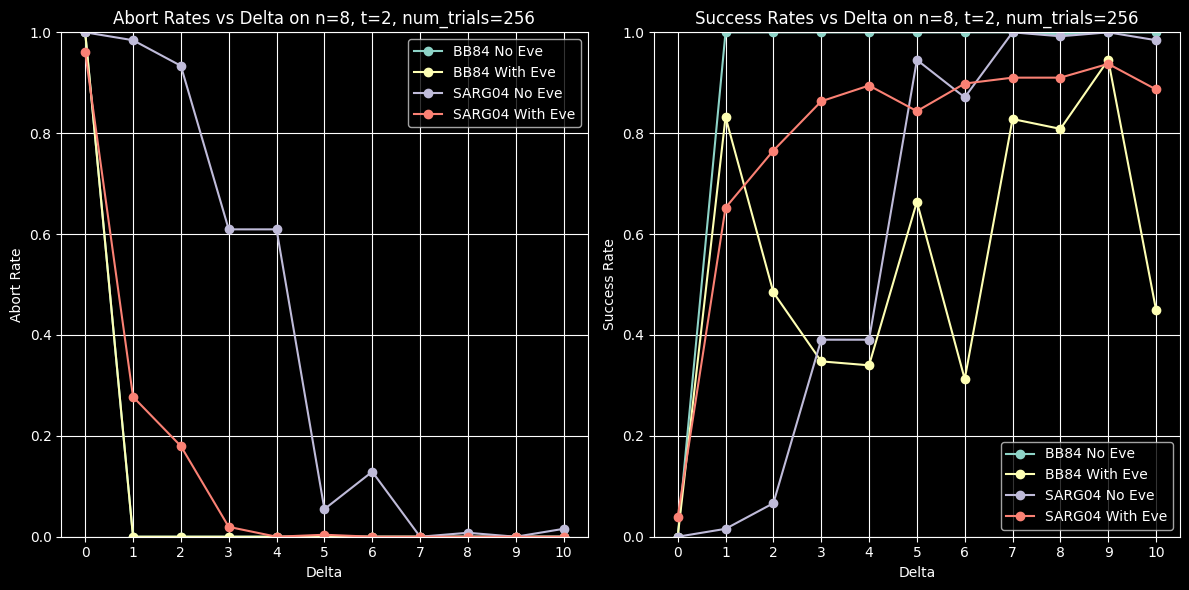

In [16]:
# Plotting the abort/success rates vs delta
abort_rates_bb84_no_eve = [res["aggr_results"]["abort_rate"] for res in results_bb84_no_eve]
success_rates_bb84_no_eve = [res["aggr_results"]["successful_rate"] for res in results_bb84_no_eve]
abort_rates_bb84_w_eve = [res["aggr_results"]["abort_rate"] for res in results_bb84_w_eve]
success_rates_bb84_w_eve = [res["aggr_results"]["successful_rate"] for res in results_bb84_w_eve]
abort_rates_sarg04_no_eve = [res["aggr_results"]["abort_rate"] for res in results_sarg04_no_eve]
success_rates_sarg04_no_eve = [res["aggr_results"]["successful_rate"] for res in results_sarg04_no_eve]
abort_rates_sarg04_w_eve = [res["aggr_results"]["abort_rate"] for res in results_sarg04_w_eve]
success_rates_sarg04_w_eve = [res["aggr_results"]["successful_rate"] for res in results_sarg04_w_eve]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(deltas, abort_rates_bb84_no_eve, marker="o", label="BB84 No Eve")
plt.plot(deltas, abort_rates_bb84_w_eve, marker="o", label="BB84 With Eve")
plt.plot(deltas, abort_rates_sarg04_no_eve, marker="o", label="SARG04 No Eve")
plt.plot(deltas, abort_rates_sarg04_w_eve, marker="o", label="SARG04 With Eve")
plt.title(f"Abort Rates vs Delta on n={n}, t={t}, num_trials={num_trials}")
plt.xlabel("Delta")
plt.xticks(deltas)
plt.ylabel("Abort Rate")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(deltas, success_rates_bb84_no_eve, marker="o", label="BB84 No Eve")
plt.plot(deltas, success_rates_bb84_w_eve, marker="o", label="BB84 With Eve")
plt.plot(deltas, success_rates_sarg04_no_eve, marker="o", label="SARG04 No Eve")
plt.plot(deltas, success_rates_sarg04_w_eve, marker="o", label="SARG04 With Eve")
plt.title(f"Success Rates vs Delta on n={n}, t={t}, num_trials={num_trials}")
plt.xlabel("Delta")
plt.xticks(deltas)
plt.ylabel("Success Rate")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
res_bb84_no_eve_hw = run_bb84_n_sarg04_batch(
	n=8, delta=2, t=2,
	eve_present=False, sarg04=False,
	num_trials=100, run_on_hw=True,
	optimization_level=2,
	service=service,
	verbose=True
)


Running BB84 protocol batch: n=8, delta=2, t=2, no Eve, on hardware, num_trials=100, optimization_level=2

[1/5] Creating circuits...
Created 100 circuits.

[2/5] Setting up backend...
Available backends: [<IBMBackend('ibm_fez')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_marrakesh')>]
Backend set up: ibm_torino

[3/5] Transpiling circuits...
Transpiled 100 circuits.

[4/5] Running circuits...
	 Job ID: d59hprbht8fs73a4o2j0
	 Patiently awaiting results...
Execution complete!

[5/5] Extracting and analyzing results...
Done! Total time: 0:00:13.552670
Backend result summary:
{
    "backend_name": "ibm_torino",
    "timestamp_created": "2025-12-30T00:29:33.797226Z",
    "timestamp_finished": "2025-12-30T00:29:39.432342Z",
    "aggr_results": {
        "total_trials": 100,
        "abort_count": 0,
        "abort_rate": 0.0,
        "tmm_count": 0,
        "tmm_rate": 0.0,
        "successful_count": 100,
        "successful_rate": 1.0,
        "mean_qber_cb": 0.01,
        "std_qber_c

In [48]:
# Run simulation tests for how delta affects the abort/success rates on hardware
num_trials = 256
n = 8
t = 2
deltas = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
run_on_hw = True
optimization_level = 2
results_bb84_no_eve_hw = []
results_bb84_w_eve_hw = []
results_sarg04_no_eve_hw = []
results_sarg04_w_eve_hw = []

service = QiskitRuntimeService(token=os.environ["IBM_TOKEN"], channel="ibm_cloud", instance=os.environ["IBM_CRN"])

for delta in deltas:
	print(f"\ndelta={delta}:")
	print(f"Running bb84_no_eve...")
	result_bb84_no_eve_hw = run_bb84_n_sarg04_batch(
		n=n, delta=delta, t=t,
		eve_present=False, sarg04=False,
		num_trials=num_trials, run_on_hw=run_on_hw,
		optimization_level=optimization_level,
		service=service,
		verbose=False
	)
	results_bb84_no_eve_hw.append(result_bb84_no_eve_hw)

	#print(f"Running bb84_w_eve...")
	#result_bb84_w_eve_hw = run_bb84_n_sarg04_batch(
	#	n=n, delta=delta, t=t,
	#	eve_present=True, sarg04=False,
	#	num_trials=num_trials, run_on_hw=run_on_hw,
	#	optimization_level=optimization_level,
	#	service=service,
	#	verbose=False
	#)
	#results_bb84_w_eve_hw.append(result_bb84_w_eve_hw)

	print(f"Running sarg04_no_eve...")
	result_sarg04_no_eve_hw = run_bb84_n_sarg04_batch(
		n=n, delta=delta, t=t,
		eve_present=False, sarg04=True,
		num_trials=num_trials, run_on_hw=run_on_hw,
		optimization_level=optimization_level,
		service=service,
		verbose=False
	)
	results_sarg04_no_eve_hw.append(result_sarg04_no_eve_hw)

	#print(f"Running sarg04_w_eve...")
	#result_sarg04_w_eve_hw = run_bb84_n_sarg04_batch(
	#	n=n, delta=delta, t=t,
	#	eve_present=True, sarg04=True,
	#	num_trials=num_trials, run_on_hw=run_on_hw,
	#	optimization_level=optimization_level,
	#	service=service,
	#	verbose=False
	#)
	#results_sarg04_w_eve_hw.append(result_sarg04_w_eve_hw)

qiskit_runtime_service._discover_account:WARNING:2025-12-30 01:58:54,154: Loading account with the given token. A saved account will not be used.



delta=0:
Running bb84_no_eve...
Running sarg04_no_eve...

delta=1:
Running bb84_no_eve...
Running sarg04_no_eve...

delta=2:
Running bb84_no_eve...
Running sarg04_no_eve...

delta=3:
Running bb84_no_eve...
Running sarg04_no_eve...

delta=4:
Running bb84_no_eve...
Running sarg04_no_eve...

delta=5:
Running bb84_no_eve...
Running sarg04_no_eve...

delta=6:
Running bb84_no_eve...
Running sarg04_no_eve...

delta=7:
Running bb84_no_eve...
Running sarg04_no_eve...

delta=8:
Running bb84_no_eve...
Running sarg04_no_eve...

delta=9:
Running bb84_no_eve...
Running sarg04_no_eve...

delta=10:
Running bb84_no_eve...
Running sarg04_no_eve...


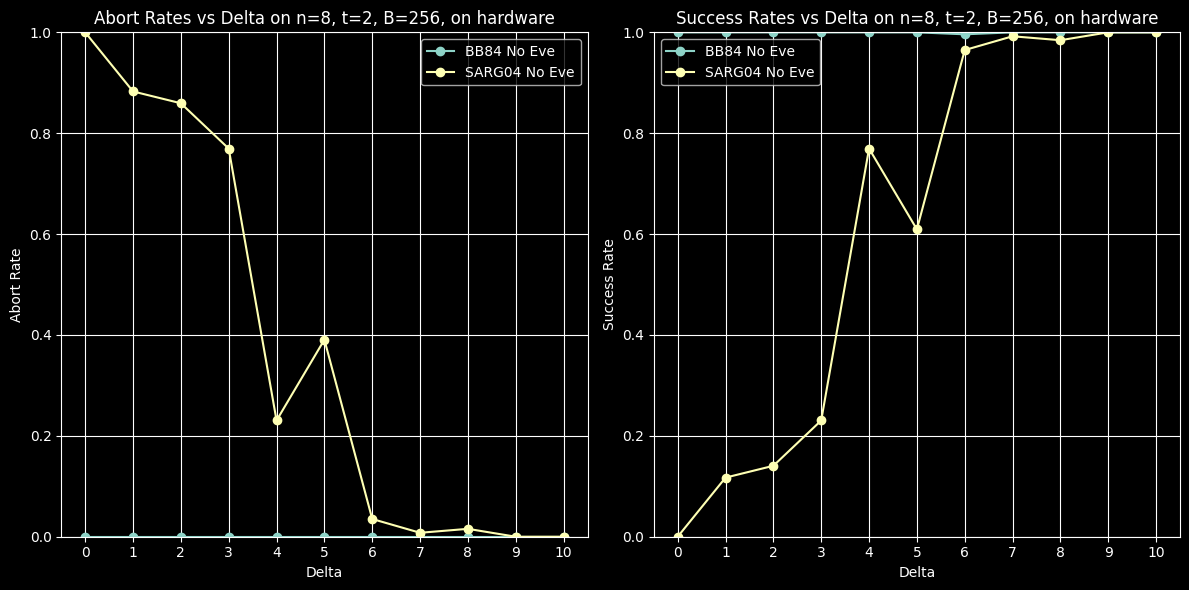

In [49]:
# Plotting the abort/success rates vs delta on hardware
abort_rates_bb84_no_eve_hw = [res["aggr_results"]["abort_rate"] for res in results_bb84_no_eve_hw]
success_rates_bb84_no_eve_hw = [res["aggr_results"]["successful_rate"] for res in results_bb84_no_eve_hw]
#abort_rates_bb84_w_eve_hw = [res["aggr_results"]["abort_rate"] for res in results_bb84_w_eve_hw]
#success_rates_bb84_w_eve_hw = [res["aggr_results"]["successful_rate"] for res in results_bb84_w_eve_hw]
abort_rates_sarg04_no_eve_hw = [res["aggr_results"]["abort_rate"] for res in results_sarg04_no_eve_hw]
success_rates_sarg04_no_eve_hw = [res["aggr_results"]["successful_rate"] for res in results_sarg04_no_eve_hw]
#abort_rates_sarg04_w_eve_hw = [res["aggr_results"]["abort_rate"] for res in results_sarg04_w_eve_hw]
#success_rates_sarg04_w_eve_hw = [res["aggr_results"]["successful_rate"] for res in results_sarg04_w_eve_hw]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(deltas, abort_rates_bb84_no_eve_hw, marker="o", label="BB84 No Eve")
#plt.plot(deltas, abort_rates_bb84_w_eve_hw, marker="o", label="BB84 With Eve")
plt.plot(deltas, abort_rates_sarg04_no_eve_hw, marker="o", label="SARG04 No Eve")
#plt.plot(deltas, abort_rates_sarg04_w_eve_hw, marker="o", label="SARG04 With Eve")
plt.title(f"Abort Rates vs Delta on n={n}, t={t}, B={num_trials}, on hardware")
plt.xlabel("Delta")
plt.xticks(deltas)
plt.ylabel("Abort Rate")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(deltas, success_rates_bb84_no_eve_hw, marker="o", label="BB84 No Eve")
#plt.plot(deltas, success_rates_bb84_w_eve_hw, marker="o", label="BB84 With Eve")
plt.plot(deltas, success_rates_sarg04_no_eve_hw, marker="o", label="SARG04 No Eve")
#plt.plot(deltas, success_rates_sarg04_w_eve_hw, marker="o", label="SARG04 With Eve")
plt.title(f"Success Rates vs Delta on n={n}, t={t}, B={num_trials}, on hardware")
plt.xlabel("Delta")
plt.xticks(deltas)
plt.ylabel("Success Rate")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Run simulation tests for how delta affects the abort/success rates on hardware
num_trials = 256
n = 16
t = 2
deltas = [0, 1, 2, 3, 4]
run_on_hw = True
optimization_level = 2
results_bb84_no_eve_hw_ = []
results_bb84_w_eve_hw_ = []
results_sarg04_no_eve_hw_ = []
results_sarg04_w_eve_hw_ = []

service = QiskitRuntimeService(token=os.environ["IBM_TOKEN"], channel="ibm_cloud", instance=os.environ["IBM_CRN"])

for delta in deltas:
	print(f"\ndelta={delta}:")
	print(f"Running bb84_no_eve...")
	result_bb84_no_eve_hw_ = run_bb84_n_sarg04_batch(
		n=n, delta=delta, t=t,
		eve_present=False, sarg04=False,
		num_trials=num_trials, run_on_hw=run_on_hw,
		optimization_level=optimization_level,
		service=service,
		verbose=False
	)
	results_bb84_no_eve_hw_.append(result_bb84_no_eve_hw_)

	#print(f"Running bb84_w_eve...")
	#result_bb84_w_eve_hw = run_bb84_n_sarg04_batch(
	#	n=n, delta=delta, t=t,
	#	eve_present=True, sarg04=False,
	#	num_trials=num_trials, run_on_hw=run_on_hw,
	#	optimization_level=optimization_level,
	#	service=service,
	#	verbose=False
	#)
	#results_bb84_w_eve_hw.append(result_bb84_w_eve_hw)

	print(f"Running sarg04_no_eve...")
	result_sarg04_no_eve_hw_ = run_bb84_n_sarg04_batch(
		n=n, delta=delta, t=t,
		eve_present=False, sarg04=True,
		num_trials=num_trials, run_on_hw=run_on_hw,
		optimization_level=optimization_level,
		service=service,
		verbose=False
	)
	results_sarg04_no_eve_hw_.append(result_sarg04_no_eve_hw_)

	#print(f"Running sarg04_w_eve...")
	#result_sarg04_w_eve_hw = run_bb84_n_sarg04_batch(
	#	n=n, delta=delta, t=t,
	#	eve_present=True, sarg04=True,
	#	num_trials=num_trials, run_on_hw=run_on_hw,
	#	optimization_level=optimization_level,
	#	service=service,
	#	verbose=False
	#)
	#results_sarg04_w_eve_hw.append(result_sarg04_w_eve_hw)

qiskit_runtime_service._discover_account:WARNING:2025-12-30 02:46:43,129: Loading account with the given token. A saved account will not be used.



delta=0:
Running bb84_no_eve...
Running sarg04_no_eve...

delta=1:
Running bb84_no_eve...
Running sarg04_no_eve...

delta=2:
Running bb84_no_eve...
Running sarg04_no_eve...

delta=3:
Running bb84_no_eve...
Running sarg04_no_eve...

delta=4:
Running bb84_no_eve...
Running sarg04_no_eve...


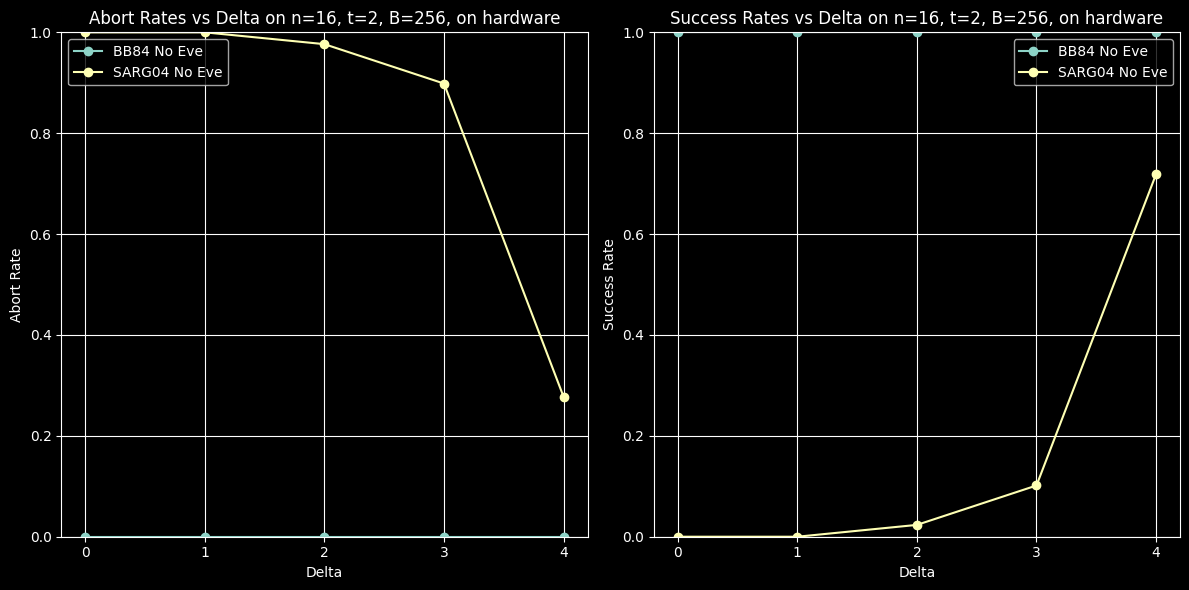

In [10]:
# Plotting the abort/success rates vs delta on hardware
abort_rates_bb84_no_eve_hw_ = [res["aggr_results"]["abort_rate"] for res in results_bb84_no_eve_hw_]
success_rates_bb84_no_eve_hw_ = [res["aggr_results"]["successful_rate"] for res in results_bb84_no_eve_hw_]
#abort_rates_bb84_w_eve_hw = [res["aggr_results"]["abort_rate"] for res in results_bb84_w_eve_hw]
#success_rates_bb84_w_eve_hw = [res["aggr_results"]["successful_rate"] for res in results_bb84_w_eve_hw]
abort_rates_sarg04_no_eve_hw_ = [res["aggr_results"]["abort_rate"] for res in results_sarg04_no_eve_hw_]
success_rates_sarg04_no_eve_hw_ = [res["aggr_results"]["successful_rate"] for res in results_sarg04_no_eve_hw_]
#abort_rates_sarg04_w_eve_hw = [res["aggr_results"]["abort_rate"] for res in results_sarg04_w_eve_hw]
#success_rates_sarg04_w_eve_hw = [res["aggr_results"]["successful_rate"] for res in results_sarg04_w_eve_hw]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(deltas, abort_rates_bb84_no_eve_hw_, marker="o", label="BB84 No Eve")
#plt.plot(deltas, abort_rates_bb84_w_eve_hw, marker="o", label="BB84 With Eve")
plt.plot(deltas, abort_rates_sarg04_no_eve_hw_, marker="o", label="SARG04 No Eve")
#plt.plot(deltas, abort_rates_sarg04_w_eve_hw, marker="o", label="SARG04 With Eve")
plt.title(f"Abort Rates vs Delta on n={n}, t={t}, B={num_trials}, on hardware")
plt.xlabel("Delta")
plt.xticks(deltas)
plt.ylabel("Abort Rate")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(deltas, success_rates_bb84_no_eve_hw_, marker="o", label="BB84 No Eve")
#plt.plot(deltas, success_rates_bb84_w_eve_hw, marker="o", label="BB84 With Eve")
plt.plot(deltas, success_rates_sarg04_no_eve_hw_, marker="o", label="SARG04 No Eve")
#plt.plot(deltas, success_rates_sarg04_w_eve_hw, marker="o", label="SARG04 With Eve")
plt.title(f"Success Rates vs Delta on n={n}, t={t}, B={num_trials}, on hardware")
plt.xlabel("Delta")
plt.xticks(deltas)
plt.ylabel("Success Rate")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()